In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    validation_split=0.2  
)
# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    './Animals',  
    target_size=(75, 75),  
    color_mode='grayscale', 
    batch_size=32, 
    class_mode='binary', 
    subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    './Animals',
    target_size=(75, 75),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation' 
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    './test', 
    target_size=(75, 75),
    color_mode='grayscale',
    class_mode='binary' 
)


Found 23250 images belonging to 2 classes.
Found 5812 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


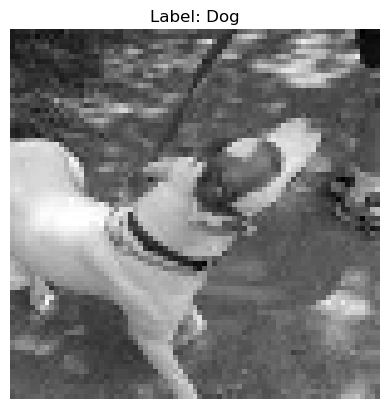

In [11]:
# Get a batch of images and labels from the train generator
images, labels = next(train_generator)

# Get the first image and its corresponding label
first_image = images[0]  # First image in the batch
first_label = labels[0]  # Corresponding label for the first image

# Plot the first image
plt.imshow(first_image.squeeze(), cmap='gray') 
plt.title(f"Label: {'Cat' if first_label == 0 else 'Dog'}") 
plt.axis('off')  # Hide axes
plt.show()

In [12]:
def plot_training_metrics(history, title):
    """
    Plots the training and validation loss and accuracy for a given model's history.

    Parameters:
    history: The History object returned by model.fit().
    model_name: Name of the model for title display.
    """
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [30]:
def print_classification_report(model, test_generator, model_name):
    # Get the true labels from the generator (y_true)
    y_true = test_generator.classes

    # Get the class labels (the classes in the generator)
    class_labels = test_generator.class_indices
    class_labels = {v: k for k, v in class_labels.items()}  # Reverse mapping
    
    # Predict on batches of data using the test generator
    y_pred = model.predict(test_generator, verbose=1)  # Get predictions for the entire dataset
    
    # Convert probabilities to 0 or 1 for binary classification
    y_pred = (y_pred > 0.5).astype(int)  # Threshold predictions at 0.5
    
    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=list(class_labels.values())))


In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 1)),  # Grayscale input
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  
])

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8,
)

Epoch 1/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 77s 103ms/step - accuracy: 0.5885 - loss: 0.6619 - val_accuracy: 0.6991 - val_loss: 0.5944
Epoch 2/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 75s 102ms/step - accuracy: 0.7370 - loss: 0.5331 - val_accuracy: 0.7445 - val_loss: 0.5125
Epoch 3/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 75s 103ms/step - accuracy: 0.7828 - loss: 0.4610 - val_accuracy: 0.7481 - val_loss: 0.5206
Epoch 4/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 78s 107ms/step - accuracy: 0.8102 - loss: 0.4095 - val_accuracy: 0.7583 - val_loss: 0.5116
Epoch 5/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 75s 103ms/step - accuracy: 0.8469 - loss: 0.3408 - val_accuracy: 0.7595 - val_loss: 0.5254
Epoch 6/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 75s 103ms/step - accuracy: 0.8791 - loss: 0.2751 - val_accuracy: 0.7779 - val_loss: 0.5153
Epoch 7/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.9209 - loss: 0.1954 - val_accuracy: 0.7806 - val_loss: 0.6055
Epoch 8/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.9521 - loss: 0.1262 - 

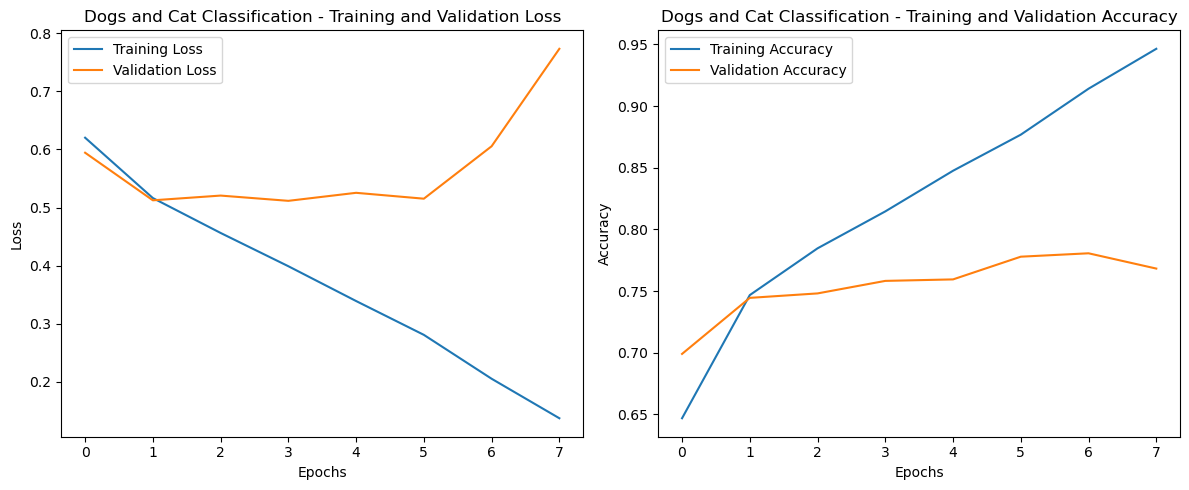

In [23]:
plot_training_metrics(history, "Dogs and Cat Classification")

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6869 - loss: 1.0619
Test Accuracy: 67.97%


In [24]:
print_classification_report(model,test_generator, "Brain Tumor CNN")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report for Brain Tumor CNN:

              precision    recall  f1-score   support

        cats       0.50      1.00      0.67       499
        dogs       0.00      0.00      0.00       500

    accuracy                           0.50       999
   macro avg       0.25      0.50      0.33       999
weighted avg       0.25      0.50      0.33       999



C:\Users\PBS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PBS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PBS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
model = Sequential([
    # First Convolutional Layer with Padding and Stride
    Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1), input_shape=(75, 75, 1)),  
    MaxPooling2D((2, 2)),

    # Second Convolutional Layer with Padding and Stride
    Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)), 
    MaxPooling2D((2, 2)),

    # Third Convolutional Layer with Padding and Stride
    Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid') 
])


In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8
)

Epoch 1/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 94s 127ms/step - accuracy: 0.6044 - loss: 0.6540 - val_accuracy: 0.7063 - val_loss: 0.5766
Epoch 2/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 101s 138ms/step - accuracy: 0.7431 - loss: 0.5170 - val_accuracy: 0.6949 - val_loss: 0.6350
Epoch 3/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 97s 134ms/step - accuracy: 0.7943 - loss: 0.4395 - val_accuracy: 0.7288 - val_loss: 0.5601
Epoch 4/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 98s 134ms/step - accuracy: 0.8291 - loss: 0.3781 - val_accuracy: 0.7474 - val_loss: 0.5384
Epoch 5/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 97s 133ms/step - accuracy: 0.8589 - loss: 0.3200 - val_accuracy: 0.7650 - val_loss: 0.5386
Epoch 6/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 98s 135ms/step - accuracy: 0.8849 - loss: 0.2663 - val_accuracy: 0.7920 - val_loss: 0.4825
Epoch 7/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 95s 130ms/step - accuracy: 0.9163 - loss: 0.2082 - val_accuracy: 0.7517 - val_loss: 0.5865
Epoch 8/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 102s 140ms/step - accuracy: 0.9404 - loss: 0.1555 

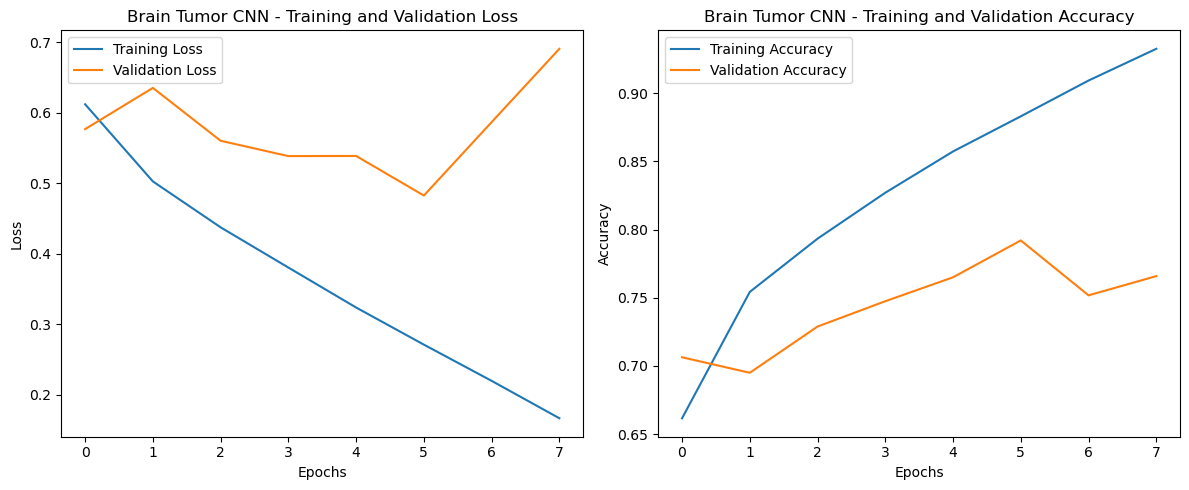

In [31]:
plot_training_metrics(history, "Dogs and Cat Classification")

In [34]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print_classification_report(model,test_generator, "Brain Tumor CNN")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6553 - loss: 1.0991
Test Accuracy: 68.17%
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Classification Report for Brain Tumor CNN:

              precision    recall  f1-score   support

        cats       0.52      0.43      0.47       499
        dogs       0.52      0.61      0.56       500

    accuracy                           0.52       999
   macro avg       0.52      0.52      0.51       999
weighted avg       0.52      0.52      0.51       999



In [36]:
model = Sequential([
    # First Convolutional Layer with Padding and Stride
    Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1), input_shape=(75, 75, 1)),  
    AveragePooling2D((2, 2)),

    # Second Convolutional Layer with Padding and Stride
    Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)), 
    AveragePooling2D((2, 2)),

    # Third Convolutional Layer with Padding and Stride
    Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    AveragePooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid') 
])


In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8
)

Epoch 1/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 99s 133ms/step - accuracy: 0.5418 - loss: 0.6857 - val_accuracy: 0.5962 - val_loss: 0.7167
Epoch 2/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 98s 134ms/step - accuracy: 0.6952 - loss: 0.5767 - val_accuracy: 0.7022 - val_loss: 0.5842
Epoch 3/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 97s 133ms/step - accuracy: 0.7411 - loss: 0.5187 - val_accuracy: 0.7158 - val_loss: 0.5699
Epoch 4/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 98s 135ms/step - accuracy: 0.7841 - loss: 0.4536 - val_accuracy: 0.7514 - val_loss: 0.5289
Epoch 5/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 98s 135ms/step - accuracy: 0.8227 - loss: 0.3946 - val_accuracy: 0.7109 - val_loss: 0.6180
Epoch 6/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 100s 138ms/step - accuracy: 0.8465 - loss: 0.3472 - val_accuracy: 0.7612 - val_loss: 0.5392
Epoch 7/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 95s 130ms/step - accuracy: 0.8806 - loss: 0.2880 - val_accuracy: 0.7543 - val_loss: 0.5712
Epoch 8/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.9097 - loss: 0.2202 -

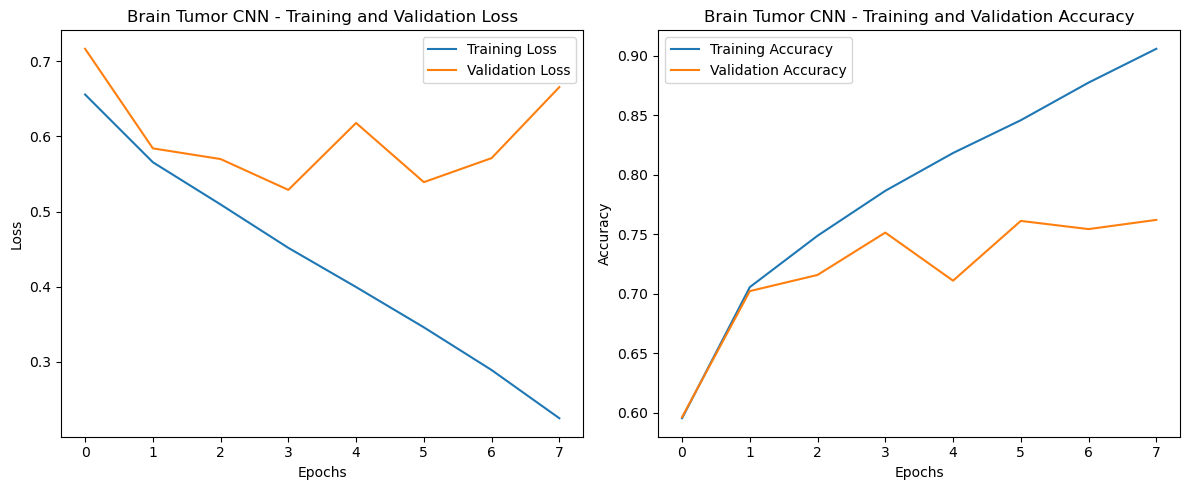

In [38]:
plot_training_metrics(history, "Dogs and Cat Classification")

In [39]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print_classification_report(model,test_generator, "Brain Tumor CNN")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7148 - loss: 0.9309
Test Accuracy: 69.97%
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Classification Report for Brain Tumor CNN:

              precision    recall  f1-score   support

        cats       0.49      0.51      0.50       499
        dogs       0.49      0.46      0.47       500

    accuracy                           0.49       999
   macro avg       0.49      0.49      0.49       999
weighted avg       0.49      0.49      0.49       999



In [40]:
model = Sequential([
    # First Convolutional Layer with Padding and Stride, using tanh activation
    Conv2D(32, (3, 3), activation='tanh', padding='same', strides=(1, 1), input_shape=(75, 75, 1)),  
    MaxPooling2D((2, 2)),

    # Second Convolutional Layer with Padding and Stride, using tanh activation
    Conv2D(64, (3, 3), activation='tanh', padding='same', strides=(1, 1)), 
    MaxPooling2D((2, 2)),

    # Third Convolutional Layer with Padding and Stride, using tanh activation
    Conv2D(128, (3, 3), activation='tanh', padding='same', strides=(1, 1)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\PBS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8
)

Epoch 1/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 102s 137ms/step - accuracy: 0.5999 - loss: 0.6664 - val_accuracy: 0.7142 - val_loss: 0.5709
Epoch 2/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 99s 136ms/step - accuracy: 0.7416 - loss: 0.5239 - val_accuracy: 0.6949 - val_loss: 0.6001
Epoch 3/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 96s 131ms/step - accuracy: 0.7854 - loss: 0.4509 - val_accuracy: 0.7373 - val_loss: 0.5530
Epoch 4/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 99s 136ms/step - accuracy: 0.8458 - loss: 0.3466 - val_accuracy: 0.7183 - val_loss: 0.6417
Epoch 5/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 104s 142ms/step - accuracy: 0.9232 - loss: 0.1939 - val_accuracy: 0.7364 - val_loss: 0.7512
Epoch 6/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 112s 153ms/step - accuracy: 0.9735 - loss: 0.0765 - val_accuracy: 0.7211 - val_loss: 1.0717
Epoch 7/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 101s 139ms/step - accuracy: 0.9866 - loss: 0.0427 - val_accuracy: 0.7330 - val_loss: 1.2317
Epoch 8/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 98s 135ms/step - accuracy: 0.9924 - loss: 0.023

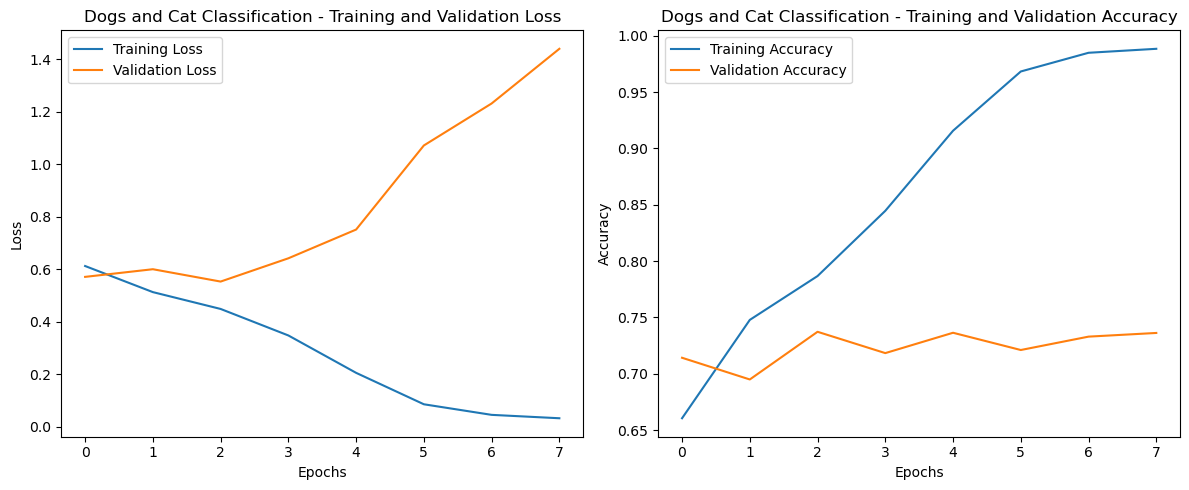

In [42]:
plot_training_metrics(history, "Dogs and Cat Classification")

In [43]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print_classification_report(model,test_generator, "Brain Tumor CNN")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6441 - loss: 2.1740
Test Accuracy: 66.87%
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Classification Report for Brain Tumor CNN:

              precision    recall  f1-score   support

        cats       0.51      0.51      0.51       499
        dogs       0.51      0.52      0.52       500

    accuracy                           0.51       999
   macro avg       0.51      0.51      0.51       999
weighted avg       0.51      0.51      0.51       999



In [44]:
model = Sequential([
    # First Convolutional Layer with Padding and Stride
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(75, 75, 1)),  # Increased filters to 64
    MaxPooling2D((2, 2)),

    # Second Convolutional Layer with Padding and Stride
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Increased filters to 128
    MaxPooling2D((2, 2)),

    # Third Convolutional Layer with Padding and Stride
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Increased filters to 256
    MaxPooling2D((2, 2)),

    Flatten(),
    
    # Increased neurons in the Dense layer
    Dense(256, activation='relu'),  # Increased neurons to 512
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=8
)

Epoch 1/8


C:\Users\PBS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


727/727 ━━━━━━━━━━━━━━━━━━━━ 263s 358ms/step - accuracy: 0.5835 - loss: 0.6642 - val_accuracy: 0.6652 - val_loss: 0.6391
Epoch 2/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 260s 357ms/step - accuracy: 0.7225 - loss: 0.5408 - val_accuracy: 0.7517 - val_loss: 0.5140
Epoch 3/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 245s 337ms/step - accuracy: 0.7883 - loss: 0.4468 - val_accuracy: 0.7218 - val_loss: 0.5587
Epoch 4/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 245s 336ms/step - accuracy: 0.8281 - loss: 0.3834 - val_accuracy: 0.7536 - val_loss: 0.5300
Epoch 5/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 247s 339ms/step - accuracy: 0.8675 - loss: 0.3035 - val_accuracy: 0.7584 - val_loss: 0.5675
Epoch 6/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 246s 339ms/step - accuracy: 0.9037 - loss: 0.2267 - val_accuracy: 0.7660 - val_loss: 0.6279
Epoch 7/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 254s 349ms/step - accuracy: 0.9505 - loss: 0.1342 - val_accuracy: 0.7763 - val_loss: 0.6801
Epoch 8/8
727/727 ━━━━━━━━━━━━━━━━━━━━ 260s 357ms/step - accuracy: 0.9740 - loss: 0.0811 - va

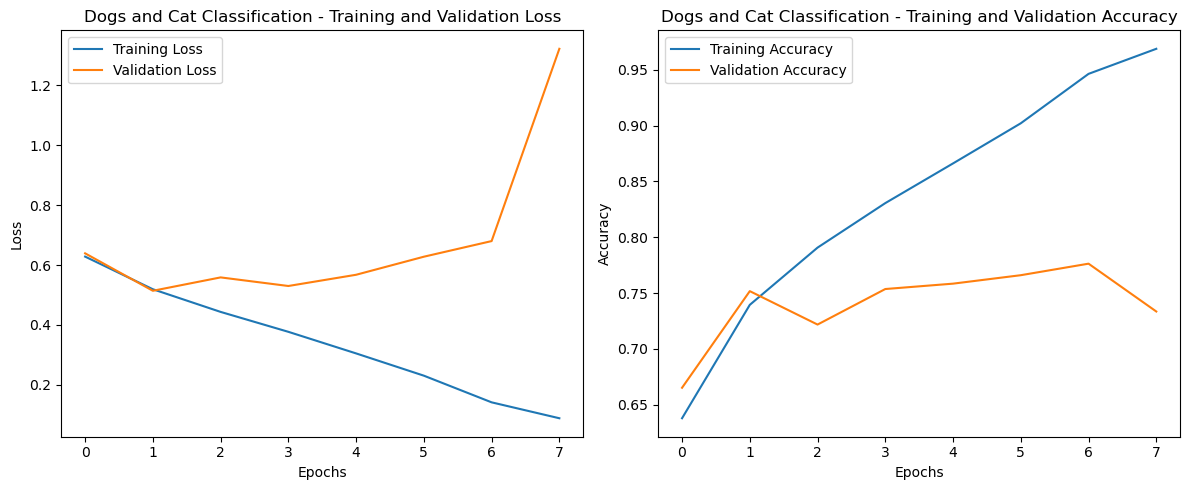

In [45]:
plot_training_metrics(history, "Dogs and Cat Classification")

In [46]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print_classification_report(model,test_generator, "Brain Tumor CNN")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7161 - loss: 1.5568
Test Accuracy: 70.27%
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
Classification Report for Brain Tumor CNN:

              precision    recall  f1-score   support

        cats       0.48      0.61      0.54       499
        dogs       0.47      0.35      0.40       500

    accuracy                           0.48       999
   macro avg       0.48      0.48      0.47       999
weighted avg       0.48      0.48      0.47       999

